# Compare two GEOS-Chem Classic datasets

## Import dependencies

In [1]:
import os
import numpy as np
import xarray as xr
import xbpch
import gcpy

# Enable auto-reloading modules
%load_ext autoreload
%autoreload 2

%matplotlib inline
import warnings; warnings.filterwarnings("ignore")

## Load data

In [2]:
#------------ CUSTOMIZE AS NEEDED ---------------
# Shared high-level directory containing your run directories
testdir = '/path/to/your/data/directories'

# Set directory to store plots
plotsdir = os.path.join(testdir,'plots')

# Define comparison type (choose one)
#comparison = 'bpch'
#comparison = 'nc'
comparison = 'bpch_vs_nc'

In [3]:
#-------------- BPCH ONLY ----------
# Edit file and directory strings as needed
if 'bpch' in comparison:
    
    # Always set bpch ref for bpch vs bpch or bpch vs nc
    refbpdir = 'bpch' # EDIT AS NEEDED (1 of 4)
    refbpdiagfile = 'trac_avg.geosfp_4x5_benchmark.201607010000' # EDIT AS NEEDED (2 of 4)
    refbpfile = os.path.join(testdir, refbpdir, refbpdiagfile)
    reftracerinfo = os.path.join(testdir,refbpdir,'tracerinfo.dat') 
    refdiaginfo = os.path.join(testdir,refbpdir,'diaginfo.dat')
    
    # Only set bpch dev is doing bpch vs bpch
    if comparison == 'bpch':
        # bpch dev
        devbpdir = 'dev_bpch' # EDIT AS NEEDED (3 of 4)
        devbpdiagfile = 'trac_avg.geosfp_4x5_benchmark.201607010000' # EDIT AS NEEDED (4 of 4)
        devbpfile = os.path.join(testdir, devbpdir, devbpdiagfile)
        devtracerinfo = os.path.join(testdir,devbpdir,'tracerinfo.dat') 
        devdiaginfo = os.path.join(testdir,devbpdir,'diaginfo.dat')
        
        # Check paths
        gcpy.check_paths(refbpfile, devbpfile)
        gcpy.check_paths(reftracerinfo, devtracerinfo)
        gcpy.check_paths(refdiaginfo, devdiaginfo)

    print('Loading and processing bpch data...')

    # Read the bpch data
    refdata = xbpch.open_bpchdataset(refbpfile, tracerinfo_file=reftracerinfo, diaginfo_file=refdiaginfo)
    refdata = refdata.transpose('time','lev','lev_edge','lat', 'lon','nv') 
    refdata = gcpy.convert_bpch_names_to_netcdf_names(refdata)    
    if comparison == 'bpch':
        devdata = xbpch.open_bpchdataset(devbpfile, tracerinfo_file=devtracerinfo, diaginfo_file=devdiaginfo)
        devdata = devdata.transpose('time','lev','lev_edge','lat', 'lon','nv')
        devdata = gcpy.convert_bpch_names_to_netcdf_names(devdata)
        
    # Change the units for concentrations. If ppb or ppbv then change to mol/mol. Will need to do this for
    # other binary diagnostic units if they are not the same as netcdf. Ideally put the mapping in a dictionary.
    conc_units = ['ppb','ppbv']
    for var in refdata.data_vars:
        if refdata[var].units.strip() in conc_units:
            refdata[var].attrs['units'] = 'mol mol-1 dry'
            refdata[var].values = refdata[var].values * 1e-9
    if comparison == 'bpch':
        for var in refdata.data_vars:
            if devdata[var].units.strip() in conc_units:
                devdata[var].attrs['units'] = 'mol mol-1 dry'
                devdata[var].values = devdata[var].values * 1e-9

    print('Complete.')
    
    # Can now compare files if bpch vs bpch since all diagnostics in one file per version (no collections)
    if comparison == 'bpch':
        [cmnvars, cmnvars1D, cmcvars2D, cmnvars3D] = gcpy.compare_varnames(refdata, devdata)

Loading and processing bpch data...
Complete.


In [4]:
#-------------- NETCDF ONLY ----------
# Edit file and directory strings as needed
if 'nc' in comparison:

    # Always set netcdf dev for nc vs nc or bpch vs nc
    devncdir = os.path.join(testdir,'nc') # EDIT AS NEEDED (1 of 2)
    
    # Only set netcdf ref if doing nc vs nc
    if comparison == 'nc':
        refncdir = os.path.join(testdir,'ref_nc') # EDIT AS NEEDED (2 of 2)
        gcpy.check_paths(refncdir, devncdir)
        
    # If doing nc vs nc, compare files to see what collections are common in both versions
    if comparison == 'nc':
        reffiles = [k for k in os.listdir(refncdir) if '.nc' in k]
        devfiles = [k for k in os.listdir(devncdir) if '.nc' in k]
        common_files = [k for k in reffiles if k in devfiles]
        refonly_files = [k for k in reffiles if k not in devfiles]
        devonly_files = [k for k in devfiles if k not in reffiles]
        print('Common files: \n{}'.format(common_files))
        print('Ref only files: \n{}'.format(refonly_files))
        print('Dev only files: \n{}'.format(devonly_files))

## Compare diagnostics

In [5]:
# Three options. Edit ref and dev strings as needed for use in plotting:

#--------------------- Option 1: bpch vs bpch -----------------------
if 'bpch' in comparison:
    refstr='bpch' # EDIT AS NEEDED
    if comparison == 'bpch':
        devstr='dev_bpch' # EDIT AS NEEDED

#--------------------- Option 2: nc vs nc ----------------------
if 'nc' in comparison:
    devstr='nc' # EDIT AS NEEDED
    if comparison == 'nc':
        refstr='ref_nc' # EDIT AS NEEDED

#--------------------- Option 3: bpch vs nc ----------------------
if comparison == 'bpch_vs_nc':
    refstr='Binary diag, 12.1.0' # EDIT AS NEEDED
    devstr='Netcdf diag, 12.1.0' # EDIT AS NEEDED
    
print('Ref: {}'.format(refstr))
print('Dev: {}'.format(devstr))

Ref: Binary diag, 12.1.0
Dev: Netcdf diag, 12.1.0


### Species concentrations

In [6]:
#------------ NetCDF diagnostics: get collection ---------------
# Edit day and time as needed
if 'nc' in comparison:
    day = '20160701' # EDIT AS NEEDED (1 of 2)
    time = '0000'    # EDIT AS NEEDED (2 of 2)
    collection = 'SpeciesConc'
    devdata = gcpy.get_collection_data(devncdir, collection, day, time)
    if comparison == 'nc':
        refdata = gcpy.get_collection_data(refncdir, collection, day, time)
    
    # If bpch vs nc then refdata will have already been defined, so can now do a comparison no matter what
    [cmnvars, cmnvars1D, cmnvars2D, cmnvars3D] = gcpy.compare_varnames(refdata, devdata)

183 common variables
995 variables in ref only (skip)
   Variable names: ['ProdSO2fromDMSandOH', 'ProdSO2fromDMSandNO3', 'ProdSO2fromDMS', 'ProdMSAfromDMS', 'ProdSO4fromGasPhase', 'ProdSO4fromH2O2inCloud', 'ProdSO4fromO3inCloud', 'PL_SUL_S_SO4o2', 'ProdSO4fromO3inSeaSalt', 'PL_SUL_S_LOH', 'PL_SUL_S_LNO3', 'ProdSO4fromOxidationOnDust', 'ProdNITfromHNO3uptakeOnDust', 'ProdSO4fromUptakeOfH2SO4g', 'LossHNO3onSeaSalt', 'ProdSO4fromHOBrInCloud', 'ProdSO4fromSRO3', 'ProdSO4fromSRHObr', 'ProdSO4fromO3s', 'PL_SUL_S_HPLUS', 'EmisDST1_Natural', 'EmisDST2_Natural', 'EmisDST3_Natural', 'EmisDST4_Natural', 'BC_ANTH_BLKC', 'BC_BIOF_BLKC', 'BC_BIOB_BLKC', 'EmisOC_Anthro', 'OC_BIOF_ORGC', 'OC_BIOB_ORGC', 'ProdBCPIfromBCPO', 'OC_BIOG_ORGC', 'ProdOCPIfromOCPO', 'OC_MTPA_MTPA', 'OC_LIMO_LIMO', 'OC_MTPO_MTPO', 'OC_SESQ_SESQ', 'PL_OC_S_TSOA', 'PL_OC_S_ISOA', 'PL_OC_S_ASOA', 'EmisSALA_Natural', 'EmisSALC_Natural', 'EmisACET_Monoterp', 'EmisACET_MethylBut', 'EmisACET_DirectBio', 'EmisACET_Ocean', 'EmisDMS_Oce

In [7]:
#------------ CUSTOMIZE VARIABLE LIST DEFINED IN THIS CELL ---------------

# All species
#desc='spc_conc'
#varlist = [k for k in cmnvars if 'SpeciesConc_' in k]

# Subset of species
desc='Dust'
varlist = [k for k in cmnvars if 'DST' in k and 'SpeciesConc' in k]

# Single species
#desc='Ozone'
#varlist = ['SpeciesConc_O3']

print('{} variables found'.format(len(varlist)))
varlist

4 variables found


['SpeciesConc_DST1',
 'SpeciesConc_DST2',
 'SpeciesConc_DST3',
 'SpeciesConc_DST4']

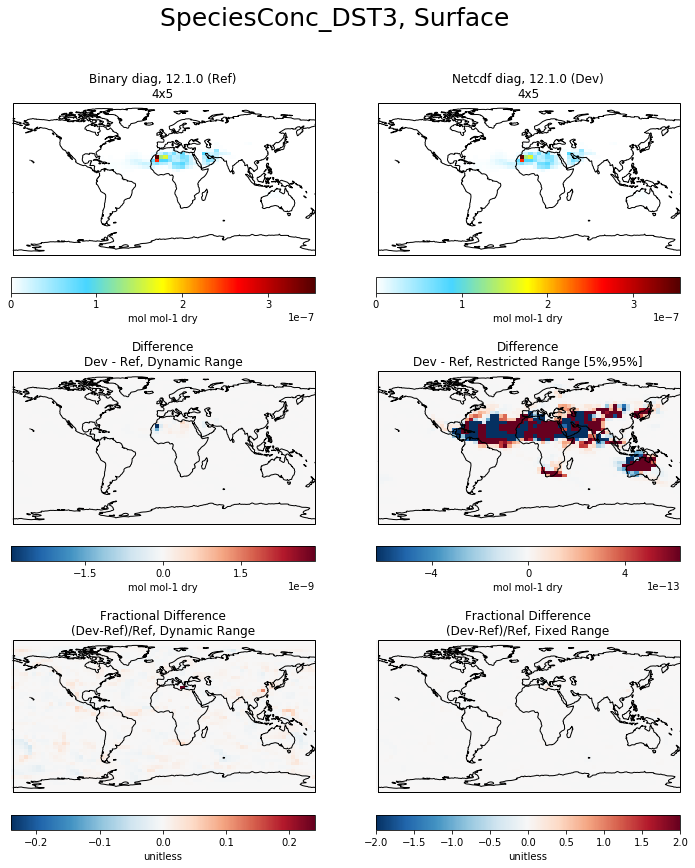

In [8]:
# Surface - quick plot
gcpy.compare_single_level( refdata, refstr, devdata, devstr, varlist=['SpeciesConc_DST3'])

In [9]:
# Surface - PDF
pdfname = os.path.join(plotsdir,'{}_surface_{}_diag.pdf'.format(desc,comparison))
gcpy.compare_single_level( refdata, refstr, devdata, devstr, varlist=varlist, 
                           savepdf=True, pdfname=pdfname )
gcpy.add_bookmarks_to_pdf( pdfname, varlist, remove_prefix='SpeciesConc_')


Creating /Users/lizzielundgren/gc/data/benchmarking/1mo_prototype/1day_test/plots/Dust_surface_bpch_vs_nc_diag.pdf for 4 variables
0 1 2 3 

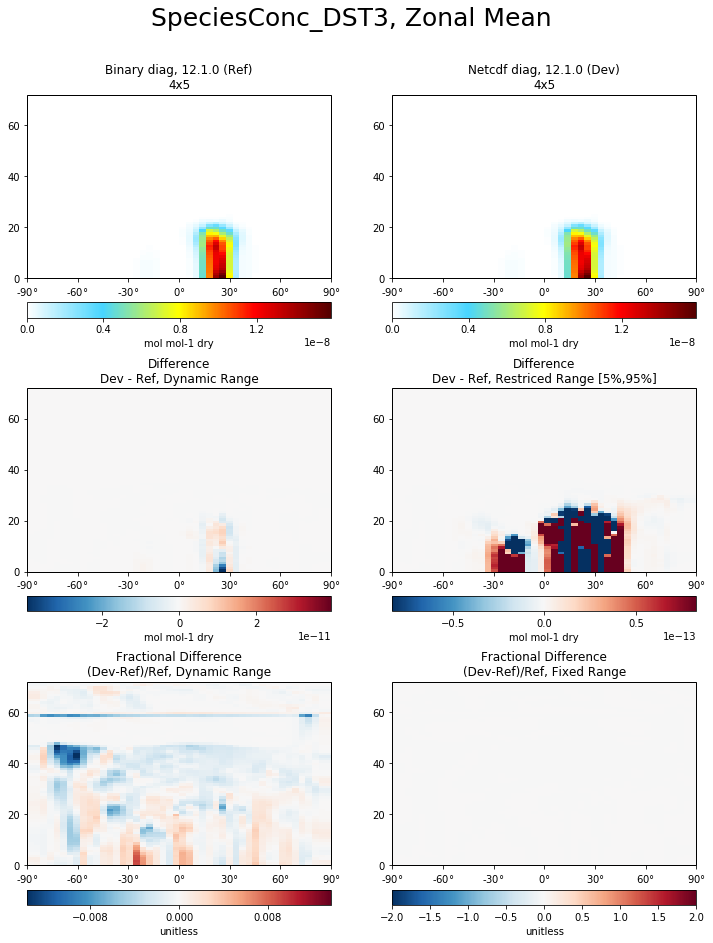

In [10]:
# Zonal mean - quick plot
gcpy.compare_zonal_mean( refdata, refstr, devdata, devstr, varlist=['SpeciesConc_DST3'])

In [11]:
# Zonal mean - PDF
pdfname = os.path.join(plotsdir,'{}_zonalmean_{}_diag.pdf'.format(desc, comparison))
gcpy.compare_zonal_mean( refdata, refstr, devdata, devstr, varlist=varlist, 
                         savepdf=True, pdfname=pdfname )
gcpy.add_bookmarks_to_pdf( pdfname, varlist, remove_prefix='SpeciesConc_')


Creating /Users/lizzielundgren/gc/data/benchmarking/1mo_prototype/1day_test/plots/Dust_zonalmean_bpch_vs_nc_diag.pdf for 4 variables
0 1 2 3 

### Emissions

In [12]:
#------------ NetCDF diagnostics only ---------------
# Edit day and time as needed
if 'nc' in comparison:
    day = '20160701' # EDIT AS NEEDED (1 of 2)
    time = '0000'    # EDIT AS NEEDED (2 of 2)
    collection = 'Emissions'
    devncdata = gcpy.get_collection_data(devncdir, collection, day, time)
    devdata = devncdata
    if comparison == 'nc':
        refdata = refncdata
        refncdata = gcpy.get_collection_data(refncdir, collection, day, time)

    # If bpch vs nc then refdata will have already been defined, so can now do a comparison no matter what
    [cmnvars, cmnvars1D, cmnvars2D, cmnvars3D] = gcpy.compare_varnames(refdata, devdata)

86 common variables
1092 variables in ref only (skip)
   Variable names: ['ProdSO2fromDMSandOH', 'ProdSO2fromDMSandNO3', 'ProdSO2fromDMS', 'ProdMSAfromDMS', 'ProdSO4fromGasPhase', 'ProdSO4fromH2O2inCloud', 'ProdSO4fromO3inCloud', 'PL_SUL_S_SO4o2', 'ProdSO4fromO3inSeaSalt', 'PL_SUL_S_LOH', 'PL_SUL_S_LNO3', 'ProdSO4fromOxidationOnDust', 'ProdNITfromHNO3uptakeOnDust', 'ProdSO4fromUptakeOfH2SO4g', 'LossHNO3onSeaSalt', 'ProdSO4fromHOBrInCloud', 'ProdSO4fromSRO3', 'ProdSO4fromSRHObr', 'ProdSO4fromO3s', 'PL_SUL_S_HPLUS', 'BC_ANTH_BLKC', 'BC_BIOF_BLKC', 'BC_BIOB_BLKC', 'EmisOC_Anthro', 'OC_BIOF_ORGC', 'OC_BIOB_ORGC', 'ProdBCPIfromBCPO', 'OC_BIOG_ORGC', 'ProdOCPIfromOCPO', 'OC_MTPA_MTPA', 'OC_LIMO_LIMO', 'OC_MTPO_MTPO', 'OC_SESQ_SESQ', 'PL_OC_S_TSOA', 'PL_OC_S_ISOA', 'PL_OC_S_ASOA', 'SO2_AN_S_SO2', 'SO2_BIOB_SO2', 'SO2_BIOF_SO2', 'SO4_AN_S_SO4', 'NH3_ANTH_NH3', 'NH3_BIOB_NH3', 'NH3_BIOF_NH3', 'AODDust', 'Met_CLDF', 'Met_OPTD', 'AerSurfAreaDust', 'AODHyg550nm_SO4', 'AerHygroscopicGrowth_SO4', 'A

In [13]:
#------------ CUSTOMIZE VARIABLE LIST DEFINED IN THIS CELL ---------------

# All emissions
#desc='emissions'
#varlist = [k for k in cmnvars if 'Emis' in k]

# Subset of emissions
desc='EmisACET'
varlist = [k for k in cmnvars if 'EmisACET' in k]

# Single emission
#desc='EmisACETAnthro'
#varlist = ['EmisACET_Anthro']

print('{} variables found'.format(len(varlist)))
varlist

8 variables found


['EmisACET_Anthro',
 'EmisACET_BioBurn',
 'EmisACET_Biofuel',
 'EmisACET_Biogenic',
 'EmisACET_DirectBio',
 'EmisACET_MethylBut',
 'EmisACET_Monoterp',
 'EmisACET_Ocean']

In [14]:
devdata['EmisACET_Anthro'].units

'atomsC/cm2/s'

In [15]:
# Surface - quick plot, one emissions
gcpy.compare_single_level( refdata, refstr, devdata, devstr, varlist=['EmisACET_Anthro'])

Ref units: count/cm2/s
Dev units: atomsC/cm2/s


AssertionError: Units do not match for EmisACET_Anthro!

The error above is due to a mismatch between the units in the bpch and the netcdf output. This is a common issue when comparing bpch and netcdf.

If you consider the two different units to be comparable then you can turn off the unit match error handling
by passing enforce_units=False to plotting subroutines. Alternatively, you can change the bpch unit when loading
and processing the data earlier in this notebook.

Ref units: count/cm2/s
Dev units: atomsC/cm2/s


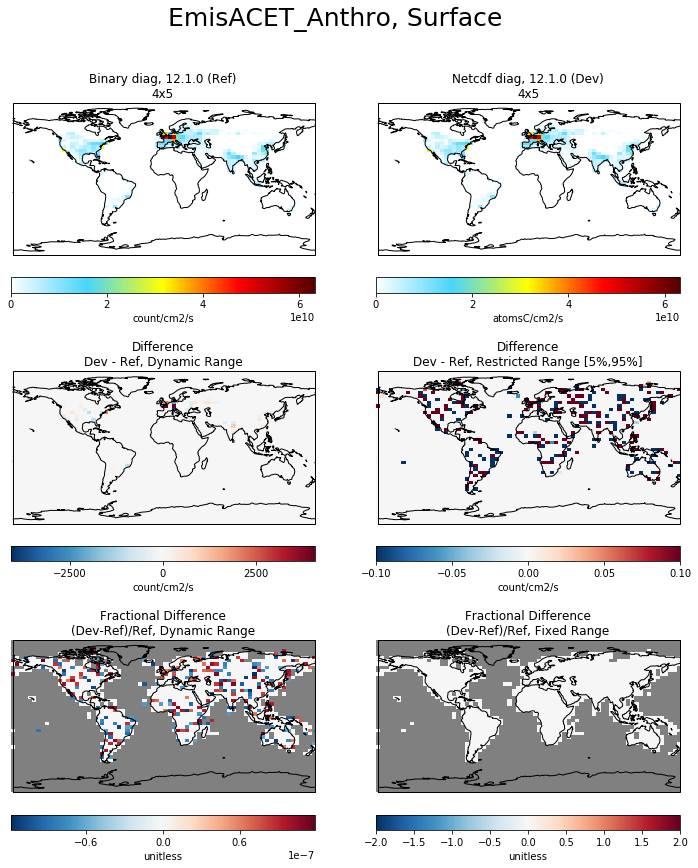

In [16]:
# Surface - quick plot, one emissions
gcpy.compare_single_level( refdata, refstr, devdata, devstr, varlist=['EmisACET_Anthro'],
                           enforce_units=False)

In [17]:
# Surface - PDF, all emissions
pdfname = os.path.join(plotsdir,'{}_surface_{}_diag.pdf'.format(desc, comparison))
gcpy.compare_single_level( refdata, refstr, devdata, devstr, varlist=varlist, 
                           savepdf=True, pdfname=pdfname, enforce_units=False )
gcpy.add_bookmarks_to_pdf( pdfname, varlist, remove_prefix='Emis')


Creating /Users/lizzielundgren/gc/data/benchmarking/1mo_prototype/1day_test/plots/EmisACET_surface_bpch_vs_nc_diag.pdf for 8 variables
0 WARNING: ref and dev concentration units do not match!
Ref units: count/cm2/s
Dev units: atomsC/cm2/s
1 2 3 4 5 6 7 

### If bpch vs nc, inspect binary diagnostic units if error encountered due to mismatch

In [18]:
# Print all unique units in bpch datasets
# unitstrs = []
# for var in refbpdata.data_vars:
#     if refbpdata[var].units.strip() not in unitstrs:
#         unitstrs.append(refbpdata[var].units.strip())
# unitstrs

In [19]:
# Look for instances of certain units in bpch and netcdf datasets
# unitstr = 'kg/m2s'

# bpvarnames = []
# for var in refbpdata.data_vars:
#     if devbpdata[var].units.strip() == unitstr:
#         bpvarnames.append(var)
# bpvarnames

# ncvarnames = []
# for var in refbpdata.data_vars:
#     if devncdata[var].units.strip() == unitstr:
#         ncvarnames.append(var)
# ncvarnames